<a href="https://colab.research.google.com/github/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_2_First_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer
Предыдущая часть: https://github.com/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_1_Dataset_Preparation.ipynb

-Work in progress (last updated:14/03/2023)-

B. Цель данного блокнота

Целью этого блокнота является обучение примитивной модели распознавания всего лишь 15 классов (функциональных групп) в спектре из 1800 точек в диапазоне 500-4100 [1/cm] 

C. План реализации

1. Импортировать табличные данные разметки классов по CAS и табличные данные уже обработанных спектров нужного диапазона.
2. Создать объект класса Dataset
3. Реализовать код для обучения модели.
4. Реализовать саму модель.
5. Обучить модель.
6. Оценить точность модели в мультиклассовом анализе (label_ranking_average_precision_score).
7. Собрать статистику.

NOTES
1. Импортированы табличные данные.

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [ ]:
!git clone https://github.com/Lamblador/IR_expert_system.git

fatal: destination path 'IR_expert_system' already exists and is not an empty directory.


In [ ]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install torchmetrics
clear_output()

In [ ]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

# Импорт табличных данных

In [ ]:
labels_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
labels_df = labels_df.set_index("CAS")
labels_df

,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,alkyne,...,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Импорт данных и обработка спектров

In [ ]:
from jcamp import jcamp_readfile
nist_ir_spectra_list_with_group = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
# Create an empty list to store spectra data
ref_spectra = []
# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('/content/IR_expert_system/downloaded_jcamp/ir/*')  # look for files without extension. Returns a list.
# Try to read the file. If can't be read, skip it.
dataset_dic = {}
for i, file in enumerate(files):
    
    #print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        sample = jcamp_readfile(file)
        #Forming data into the types
        sample['x'] = sample['x'].astype(np.float32)
        sample['y'] = sample['y'].astype(np.float32)
        sample['firstx'] = np.float32(sample['x'][0])
        #print(type(sample['firstx']))
        sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
        sample['npoints'] = int(sample['npoints'])    
        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if sample['yunits'] == "ABSORBANCE":
            pass 

        elif sample['yunits'] == "TRANSMISSION" or sample['yunits'] == "TRANSMITTANCE":
            
            sample['y'] = 1 - sample['y']
            sample['yunits'] = "ABSORBANCE"
            
            #normalize
           
        # check xunits: if in microns, change to 1/cm

        if sample['xunits'] == "MICROMETERS":
            sample['x'] = 10000 / sample['x']
            sample['xunits'] = '1/CM'
            sample['firstx'] = np.float32(sample['x'][0])
            sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
            sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
            #if sample['deltax'] == np.nan: print(float(sample['firstx'])-float(sample['lastx'])), float(sample['npoints'])
            sample['maxx'] =  np.float32(max(sample['x']))
            sample['minx'] =  np.float32(min(sample['x']))
        # check deltax: if Nan, change to (maxx-minx)/npoints
        #if sample['deltax'] == np.nan: sample['deltax'] = ((float(sample['firstx'])-float(sample['lastx']))/float(sample['npoints']))

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.
        #Flitting the x array if it is not in min_to_max order
        if sample['x'][0] > sample['x'][3]: 
           #print(sample['x'])
           sample['x'] = np.flip(sample['x'])
           #print(sample['x'])
           sample['y'] = np.flip(sample['y'])
           sample['firstx'] = np.float32(sample['x'][0])
           sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
           
        
        #Saving data to dictionary under cas num
        dataset_dic[sample['cas registry no']] = sample
        #print(sample['cas registry no'])
        # Nan check
        if np.isnan(sample['y']).any(): print("Reading jcamp problem! Nan observed in Y")
                

    except:
         print("File can't be read, please check:", file)
         continue

#print(dataset_dic)

File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/1498-65-3
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/677-43-0
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/136-84-5
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/933-18-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116594-65-1
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/94-80-4
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/77008-64-1
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/108-57-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/556-53-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/67-51-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116402-12-1
File can't be 

In [ ]:
dataset_df = pd.DataFrame(dataset_dic)
dataset_df = dataset_df.transpose()
dataset_df[['x', 'y', 'minx', 'maxx', 'npoints']]

,x,y,minx,maxx,npoints
54200-67-8,"[549.863, 551.7923, 553.7216, 555.6509, 557.58...","[0.0013999, 0.0013474, 0.0013194, 0.0012518, 0...",549.863,3999.53,1789
14749-45-2,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.001904408, 0.005963804, 0.009421808, 0.0048...",450,3966,880
19244-82-7,"[625.51996, 625.7879, 626.0561, 626.3246, 626....","[0.45499998, 0.453, 0.453, 0.453, 0.453, 0.452...",625.519958,5000.0,2049
2439-54-5,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.00294, 0.00269, 0.00243, 0.00235, 0.00252, ...",549.759,4000.7,1790
19550-75-5,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0001596, 0.0001288, 5.88e-05, 1.4e-05, 0.0,...",550,3846,825
...,...,...,...,...,...
102-09-0,"[598.033, 598.6887, 599.3445, 600.00024, 600.6...","[0.213, 0.21200001, 0.21200001, 0.21100003, 0....",598.033,3998.04,5186
1124-26-1,"[667.5746, 667.78925, 668.0023, 668.2156, 668....","[0.3006, 0.3171, 0.28430003, 0.3268, 0.3471999...",667.574585,4870.920898,2707
80-30-8,"[392.0, 393.0, 394.0, 395.0, 396.0, 397.0, 398...","[0.17519999, 0.17549998, 0.17570001, 0.176, 0....",392,3794,3403
625-58-1,"[456.012, 456.89175, 457.77155, 458.6513, 459....","[0.041999996, 0.041999996, 0.041999996, 0.0400...",456.012,3805.28,3808


In [ ]:
#Добавление к краям с исходным шагом крайнего значения y.
def padding_ir_below(x, y, low_border):
  '''
    x, y - array-like data
    low_border - border until which padding will continue 

    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[0]-deltax
  while next_x > low_border:
    x.insert(0, next_x)
    y.insert(0, y[0])
    next_x = x[0]-deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.insert(0, next_x)
  y.insert(0, y[0])
  next_x = x[0]-deltax
  return x, y

def padding_ir_above(x, y, high_border):
  '''
    x, y - array-like data
    high_border - border until which padding will continue 


    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[-1]+deltax
  while next_x < high_border:
    x.append(next_x)
    y.append(y[-1])
    next_x = x[-1]+deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.append(next_x)
  y.append(y[-1])
  next_x = x[-1]+deltax
  return x, y

from scipy import interpolate

def interpolate_in_borders_with_delta(x, y, borders = [500, 4100], deltax = 2):
  '''
  x, y - array like data
  borders - list of [low_border, high border]
  deltax - increment of new data

  returns new x, y data as lists with increment = deltax
  '''
  x, y = list(x), list(y)
  f = interpolate.interp1d(x, y)
  #print(f(x[0]))
  x_new = []
  for i in range(borders[0], borders[1], deltax):
    x_new.append(i)
  x_new = np.array(x_new)
  y_new = f(x_new)
  
  return x_new, y_new



In [ ]:
x_list, y_list = [], []
errors = 0
for i in tqdm(range(len(dataset_df[['x']]))):
  try:
      x, y = dataset_df[['x']].iloc[i].tolist(), dataset_df[['y']].iloc[i].tolist()
      x1, y1 = padding_ir_below(x[0], y[0], 500.0)

      x2, y2 = padding_ir_above(x1, y1, 4100.0)
  
      x3, y3 = interpolate_in_borders_with_delta(x2, y2)
      x_list.append(x3)
      y_list.append(y3)
  except ValueError:
      #print(f'0: {len(x)}, {len(y)}, 1: {len(x1)}, {len(y1)}, 2: {len(x2)}, {len(y2)}')
      errors +=1
      x_list.append(np.nan)
      y_list.append(np.nan) 
print(f'Found {errors} errors')

100%|██████████| 14346/14346 [01:12<00:00, 197.05it/s]

Found 38 errors


In [ ]:
x_serie = pd.Series(x_list)
y_serie = pd.Series(y_list)

In [ ]:
df = pd.DataFrame(x_serie, columns = ['x1'])
df['y1'] = y_serie
df

,x1,y1
0,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0013998999493196607, 0.0013998999493196607,..."
1,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.008544777985662222, 0.008820416405797005, 0..."
2,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.45499998331069946, 0.45499998331069946, 0.4..."
3,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.002940000034868717, 0.002940000034868717, 0..."
4,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.00015959999291226268, 0.0001595999929122626..."
...,...,...
14341,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.21299999952316284, 0.21299999952316284, 0.2..."
14342,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.30059999227523804, 0.30059999227523804, 0.3..."
14343,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.29250001907348633, 0.2821999788284302, 0.27..."
14344,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0350000262260437, 0.03200000524520874, 0.03..."


In [ ]:
dataset_df = dataset_df.reset_index()
dataset_df1 = dataset_df.join(df, lsuffix='x')
dataset_df1[['x', 'x1', 'y', 'y1']]

,x,x1,y,y1
0,"[549.863, 551.7923, 553.7216, 555.6509, 557.58...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0013999, 0.0013474, 0.0013194, 0.0012518, 0...","[0.0013998999493196607, 0.0013998999493196607,..."
1,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.001904408, 0.005963804, 0.009421808, 0.0048...","[0.008544777985662222, 0.008820416405797005, 0..."
2,"[625.51996, 625.7879, 626.0561, 626.3246, 626....","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.45499998, 0.453, 0.453, 0.453, 0.453, 0.452...","[0.45499998331069946, 0.45499998331069946, 0.4..."
3,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.00294, 0.00269, 0.00243, 0.00235, 0.00252, ...","[0.002940000034868717, 0.002940000034868717, 0..."
4,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0001596, 0.0001288, 5.88e-05, 1.4e-05, 0.0,...","[0.00015959999291226268, 0.0001595999929122626..."
...,...,...,...,...
14341,"[598.033, 598.6887, 599.3445, 600.00024, 600.6...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.213, 0.21200001, 0.21200001, 0.21100003, 0....","[0.21299999952316284, 0.21299999952316284, 0.2..."
14342,"[667.5746, 667.78925, 668.0023, 668.2156, 668....","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.3006, 0.3171, 0.28430003, 0.3268, 0.3471999...","[0.30059999227523804, 0.30059999227523804, 0.3..."
14343,"[392.0, 393.0, 394.0, 395.0, 396.0, 397.0, 398...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.17519999, 0.17549998, 0.17570001, 0.176, 0....","[0.29250001907348633, 0.2821999788284302, 0.27..."
14344,"[456.012, 456.89175, 457.77155, 458.6513, 459....","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.041999996, 0.041999996, 0.041999996, 0.0400...","[0.0350000262260437, 0.03200000524520874, 0.03..."


In [ ]:
dataset_df1['y1'][0]

array([0.0013999, 0.0013999, 0.0013999, ..., 0.0006319, 0.0006319,
       0.0006319])

In [ ]:
dataset_df1 = dataset_df1.set_index('cas registry no')

In [ ]:
dataset_df_labeled = labels_df.join(dataset_df1)
dataset_df_labeled

,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,alkyne,...,spectral resolution,wavenumber accuracy,apodization function,low pass filter,switch gain on,$spectra version,$uncertainty in y,pressure,x1,y1
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.026076922193169594, 0.02797572687268257, 0...."
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.005049999803304672, 0.005049999803304672, 0..."
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0002783999952953309, 0.0002783999952953309,..."
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.08899998664855957, 0.08958601189397797, 0.0..."
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.20800000429153442, 0.20800000429153442, 0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.02355931419879198, 0.02319779060781002, 0.0..."
999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0013761000009253621, 0.0013761000009253621,..."
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13220000267028809, 0.1312999725341797, 0.12..."


In [ ]:
dataset_df_labeled.columns

Index(['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro', 'index',
       'title', 'jcamp-dx', 'data type', 'origin', 'owner', 'molform',
       '$nist source', 'state', 'xunits', 'yunits', 'xfactor', 'yfactor',
       'deltax', 'firstx', 'lastx', 'firsty', 'maxx', 'minx', 'maxy', 'miny',
       'npoints', 'xydata', 'end', 'x', 'y', 'filename', 'class', 'date',
       'names', 'bp', 'source reference', '$nist image',
       'spectrometer/data system', 'path length', 'sampling procedure',
       'resolution', 'data processing', 'mp', 'instrument parameters',
       'sample description', 'temperature', 'cas name', 'xlabel', 'ylabel',
       '$nist doc file', 'instrument resolution', 'ir source', 'aperture',
       'beamsplitter', 'detector', 'scanner speed', 'phas

In [ ]:
dataset_df_labeled1 = dataset_df_labeled[['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro',
       'title',
       'molform',
       'x', 'y', 'x1', 'y1']]
dataset_df_labeled1

,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,alkyne,...,ether,acyl halides,amides,nitro,title,molform,x,y,x1,y1
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,"Benzene, 1-chloro-4-nitro-",C 6 H 4 Cl N O 2,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.025064226, 0.03873562, 0.039495144, 0.01962...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.026076922193169594, 0.02797572687268257, 0...."
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,p-Nitroaniline,C 6 H 6 N 2 O 2,"[551.688, 555.546, 559.404, 563.262, 567.12, 5...","[0.00505, 0.00536, 0.00556, 0.00599, 0.00634, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.005049999803304672, 0.005049999803304672, 0..."
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4-Nitrophenol,C 6 H 5 N O 3,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0002784, 0.0001464, 0.0001752, 0.0002928, 0...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0002783999952953309, 0.0002783999952953309,..."
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,n-BUTYLTRIMETHYLSILANE,C7 H18 Si,"[203.607, 204.53778, 205.46855, 206.39932, 207...","[0.19099998, 0.19099998, 0.19099998, 0.1909999...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.08899998664855957, 0.08958601189397797, 0.0..."
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,n-BUTYL CHLORODIMETHYL SILANE,C6 H15 Cl Si,"[625.2462, 625.5054, 625.7648, 626.0244, 626.2...","[0.208, 0.208, 0.20899999, 0.208, 0.208, 0.208...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.20800000429153442, 0.20800000429153442, 0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"Benzenamine, N,N,4-trimethyl-",C 9 H 13 N,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.006145908, 0.006989464, 0.008676576, 0.0113...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.02355931419879198, 0.02319779060781002, 0.0..."
999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,"4,4-Dimethyl-2-pentyne",C 7 H 12,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0013761, 0.0011286, 0.0008943, 0.0006864, 0...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0013761000009253621, 0.0013761000009253621,..."
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"Ammonium chloride, 2-chloroethyltrimethyl-",C5 H13 Cl2 N,"[459.0, 460.0, 461.0, 462.0, 463.0, 464.0, 465...","[0.15679997, 0.15499997, 0.15319997, 0.1513000...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13220000267028809, 0.1312999725341797, 0.12..."


In [ ]:
spectra_x =dataset_df_labeled.iloc[:,-1]
spectra_x_t = torch.Tensor(spectra_x[0])
spectra_x_t

tensor([0.0261, 0.0280, 0.0325,  ..., 0.0071, 0.0071, 0.0071])

# Создание класса Dataset

Вивлеты - преобразование для детектирования пиков.

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-2]
        self.spectra_y = self.dataset_df.iloc[:,-1]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800))      
        spectra = torch.cat((spectra_x, spectra_y))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [ ]:
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1)

In [ ]:
spectra, label = dataset_ir_spectra.__getitem__(0)
spectra.size()

torch.Size([2, 1800])

In [ ]:
#Создание объекта класса и разбиение на трейн,тест и вал
from torch.utils.data import random_split
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1.dropna())
train_size = int(0.7 * len(dataset_ir_spectra))
val_size = int(0.1 * len(dataset_ir_spectra))
test_size = len(dataset_ir_spectra) - train_size - val_size
train_dataset, test_dataset = random_split(dataset_ir_spectra, [train_size, int(test_size+val_size)])
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [ ]:
#Создание загрузчиков
# Number of classes
classes = list(dataset_ir_spectra.spectra_labels.columns)
num_classes = len(classes)
num_classes

17

In [ ]:
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
print(cls2inx)
print(inx2cls)

{'alkane': 0, 'methyl': 1, 'alkene': 2, 'alkyne': 3, 'alcohols': 4, 'amines': 5, 'nitriles': 6, 'aromatics': 7, 'alkyl halides': 8, 'esters': 9, 'ketones': 10, 'aldehydes': 11, 'carboxylic acids': 12, 'ether': 13, 'acyl halides': 14, 'amides': 15, 'nitro': 16}
{0: 'alkane', 1: 'methyl', 2: 'alkene', 3: 'alkyne', 4: 'alcohols', 5: 'amines', 6: 'nitriles', 7: 'aromatics', 8: 'alkyl halides', 9: 'esters', 10: 'ketones', 11: 'aldehydes', 12: 'carboxylic acids', 13: 'ether', 14: 'acyl halides', 15: 'amides', 16: 'nitro'}


In [ ]:
dataset_ir_spectra.spectra_labels['alkane'].mean()

0.6827464492814522

In [ ]:
# Расчёт весов
wts4cls = {}
for classs in classes:
  wts4cls[classs] = dataset_ir_spectra.spectra_labels[classs].mean()
print(wts4cls)

{'alkane': 0.6827464492814522, 'methyl': 0.6216488780569795, 'alkene': 0.13555760988318347, 'alkyne': 0.019497436759391546, 'alcohols': 0.21867383813765862, 'amines': 0.13085133204470964, 'nitriles': 0.03815446676191277, 'aromatics': 0.5847550214303723, 'alkyl halides': 0.2593495251701824, 'esters': 0.11648037650222708, 'ketones': 0.09420959744516345, 'aldehydes': 0.020589965543322968, 'carboxylic acids': 0.06025716446760232, 'ether': 0.25018909152029584, 'acyl halides': 0.00966467770400874, 'amides': 0.07101437095554249, 'nitro': 0.05723170014286915}


In [ ]:
wts_list = []
for name, values in wts4cls.items():
  wts_list.append(values)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

tensor([0.6827, 0.6216, 0.1356, 0.0195, 0.2187, 0.1309, 0.0382, 0.5848, 0.2593,
        0.1165, 0.0942, 0.0206, 0.0603, 0.2502, 0.0097, 0.0710, 0.0572],
       dtype=torch.float64)


In [ ]:
#Расчёт веса образца на основе минимального веса любой функциональной группы 
labels1 = train_dataset.dataset.spectra_labels.to_numpy().copy()
labels1[labels1 == 0.0] = np.nan
train_labels = torch.tensor(labels1)
weighted_labels  = train_labels*weight_for_every_class
weights_for_every_sample = []
for label_tensor in weighted_labels:
  weight = np.nanmin(label_tensor.numpy())
  weights_for_every_sample.append(weight)

weights_for_every_sample = torch.tensor(weights_for_every_sample)
print(weights_for_every_sample)

tensor([0.0572, 0.0572, 0.0572,  ..., 0.2593, 0.0572, 0.1309],
       dtype=torch.float64)


<ipython-input-69-703c27d16706>:8: RuntimeWarning: All-NaN slice encountered
  weight = np.nanmin(label_tensor.numpy())


In [ ]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weights_for_every_sample, batch_size) 

dataloader_ir_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    #sampler= weightedsampler
)

In [ ]:
label.size(0)

17

In [ ]:
pred = label.clone()
pred[pred==1] = 0.91
pred[5] = 0.7
pred[-1] = 0.7
pred

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7000, 0.0000, 0.9100, 0.9100,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7000])

In [ ]:
pred.data[pred.data <0.9] = -1
pred.data[pred.data >=0.9] = 1
pred

tensor([-1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1.,
        -1., -1., -1.])

In [ ]:
print(label)

tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.])


In [ ]:
print(pred.data == label)
a = (pred.data == label).sum().item()
print(a)

tensor([False, False, False, False, False, False, False,  True,  True, False,
        False, False, False, False, False, False, False])
2


In [ ]:
get_correct_count(pred, label)

16

# Код для обучения

Взят из https://github.com/Gan4x4/ml_snippets/blob/main/Training/Trainer.ipynb

In [ ]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import label_ranking_average_precision_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_correct_count(pred, labels, tolerance = 0.9):
    pred.data[pred.data >=tolerance] = 1
    pred.data[pred.data <tolerance] = -1
    return (pred.data.cpu() == labels.cpu()).sum().item()

def get_correct_count_lraps(pred, labels):
    return label_ranking_average_precision_score(labels, pred.cpu().detach().numpy())
    


@torch.inference_mode()  # this annotation disable grad computation
def validate(model, test_loader, device="cpu", criterion = nn.BCELoss()):
    correct, total = 0, 0
    for ir_spec, labels in test_loader:
        pred = model(ir_spec.to(device))
        loss = criterion(pred, labels.to(device))
        #total_count = (labels.to('cpu') == 1.0).sum().item()
        #total += total_count
        #print(pred)
        #print(labels)
        #tolerance = (1.0-(1.0/(epoch+1)))-0.2
        score= get_correct_count_lraps(pred, labels)
        #print(correct)
    return score, loss

In [ ]:
class Trainer:
    def __init__(self, model, plotter=None, lr=0.001):
        self.model = model
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr
        )  # Weight update
        self.criterion = nn.BCELoss()  # Loss function
        self.plotter = ProgressPlotter() if plotter is None else plotter
        self.epochs = 2
        self.loss_hist = []
        self.loss_hist_tst = []

    def __call__(self, train_loader, val_loader, epochs=10):
        global device
        print("Using device:", device)
        self.epochs = epochs
        self.model.to(device)
        self.model.train()
        for epoch in tqdm(range(self.epochs)):
            self.loss_hist = []
            self.loss_hist_tst = []
            correct, total = 0, 0
            for ir_spec, labels in train_loader:
                score = self.process_batch(ir_spec, labels)
                #total_count = (labels.cpu() == 1.0).sum().item()
                #total += total_count
            self.plotter.add_scalar("Loss/train", np.mean(self.loss_hist))
            label_ranking_average_precision_score_val, val_loss = validate(self.model, val_loader, device=device, criterion=self.criterion)
            self.loss_hist_tst.append(val_loss.cpu())
            self.plotter.add_scalar("label_ranking_average_precision_score/val", label_ranking_average_precision_score_val)
            self.plotter.add_scalar("Loss/val", np.mean(self.loss_hist_tst))
            #self.plotter.add_scalar("label_ranking_average_precision_score/train", correct / total)
            self.plotter.display(["Loss/train", "Loss/val", "label_ranking_average_precision_score/val"])

    def process_batch(self, ir_spec, labels):
        self.optimizer.zero_grad()
        out = self.model(ir_spec.to(device))
        loss = self.criterion(out, labels.to(device))
        loss.backward()
        self.loss_hist.append(loss.item())
        self.optimizer.step()
        return get_correct_count_lraps(out.cpu(), labels)

Показывать loss на тексте, чтобы было понятно переобучение.

Взят из EX11_Learning_on_Real_data_fix.ipynb 

In [ ]:
from copy import deepcopy

from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm


class BaseTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader,
    ):
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(model.parameters())
        self.num_epochs = 10
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.best_model = None
        self.set_score_function(accuracy_score, "accuracy")
        self.pp = ProgressPlotter(title="baseline", groups=["loss"])

    def set_score_function(self, score_function, title="quality metric"):
        self.score_function = score_function
        self.quality_metric = title

    def train_epoch(self):

        self.model.train()
        loss_hist = []
        for images, labels in self.train_dataloader:
            self.optimizer.zero_grad()
            preds = self.model(images.to(self.device))
            loss = self.criterion(preds, labels.to(self.device))
            loss.backward()
            loss_hist.append(loss.detach().cpu())
            self.optimizer.step()
        return torch.stack(loss_hist).mean().item()

    def val_epoch(self):
        loss_hist = []
        self.model.eval()
        with torch.no_grad():
            for images, labels in self.test_dataloader:
                preds = self.model(images.to(self.device))
                loss = self.criterion(preds, labels.to(self.device))
                loss_hist.append(loss.detach().cpu())
        return torch.stack(loss_hist).mean()

    def fit(self, verbose=True):
        self.model.to(self.device)
        best_metric_on_val = -np.inf
        for epoch in tqdm(range(self.num_epochs)):
            loss_on_train = self.train_epoch()
            loss_on_val = self.val_epoch()

            metric_on_train = self.validate(on_train=True)
            metric_on_val = self.validate(on_train=False)

            if metric_on_val > best_metric_on_val:
                print("Best model updated")
                best_metric_on_val = metric_on_val
                self.save_best_model()

            self.pp.add_scalar(group="loss", value=loss_on_train, tag="train")
            self.pp.add_scalar(group="loss", value=loss_on_val, tag="val")
            self.pp.add_scalar(
                group=self.quality_metric, value=metric_on_train, tag="train"
            )
            self.pp.add_scalar(
                group=self.quality_metric, value=metric_on_val, tag="val"
            )

            if verbose:
                self.pp.display()

    def validate(self, on_train=False, using_best_model=False, **kwargs):

        dl = self.train_dataloader if on_train else self.test_dataloader
        model = self.best_model if using_best_model else self.model

        y_pred, y_true = self.get_predictions(model, dl)
        return self.score_function(y_pred, y_true, **kwargs)

    def get_predictions(self, model, dl):
        y_pred = torch.tensor([])
        y_true = torch.tensor([])

        with torch.no_grad():
            for i, data in enumerate(dl):
                img, label = data
                outputs = model(img.to(self.device))
                _, predicted = torch.max(outputs.data, 1)
                y_pred = torch.cat((y_pred, predicted.cpu().detach()))
                y_true = torch.cat((y_true, label))
        return y_pred, y_true

    def save_best_model(
        self,
    ):
        model_copy = deepcopy(self.model)
        self.best_model = model_copy

Код для визуализации из прошлых заданий, можно заменить его собственым.

In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="upper right")
        if history_len < 50:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

# Модель

Предлагается использовать модель с несколькими свёрточными слоями(1) и понижением размерности до 225-450, а затем с полносвязыными слоями, где на выходе одни слой из 17 меток классов.

Базовая модель: 8 сверток посчитать обучаемых параметров и потом собирать статистику.
классификейшон репорт
Потом увеличить количество свёрточных слоёв до 12. 
Увеличивать количество каналов через 1 макспул.
Выводить лосс для теста.

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
import torch.nn as nn
import torch

class TwoLayerCNN(nn.Module):
    def __init__(self, hidden_size = 34):
        super().__init__()
        self.hidden_size=hidden_size
        self.bblock = nn.Sequential(
            nn.Conv1d(2, hidden_size, kernel_size = 3, padding = 1), # in channel=2, out=hidden_size 3 - ядро свертки, таблица 1800 точек*2 столбца
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,1800] -> [hidden_size,900] 

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,900] -> [hidden_size,450] 
            
            nn.Conv1d(hidden_size, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,450] -> [hidden_size,225] 

            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(225*2*hidden_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 17),
            nn.Sigmoid()
            )

    def forward(self, x):
        # Your code here
        x = self.bblock(x) 
        return x

v0.2.1 - модель с res-связями и dropout. 

In [ ]:
from torch.nn.modules.pooling import AvgPool2d
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=3, stride=1, padding = 1) #[2,1800]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size, downsample = False), #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        #self.avgpool = nn.AvgPool1d(hidden_size*8*225)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size*8*225, 200)
        self.relu1 = nn.ReLU()
        self.do = nn.Dropout1d(0.5)
        self.fc1 = nn.Linear(200, class_nums) 
        self.sm = nn.Sigmoid()
        


    def forward(self, batch):
      # PUT YOUR CODE HERE
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer2(batch)
        batch = self.layer3(batch)
        batch = self.layer4(batch)
        batch = self.layer5(batch)
        #batch = self.avgpool(batch)
        batch = self.flatten(batch)
        batch = self.fc(batch)
        batch = self.relu1(batch)
        batch = self.fc1(batch)
        scores=self.sm(batch)
              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out
        

# Обучение модели

Оптимизатор - Адам с базовыми настройками
Лосс - Бинарная кросс-энтропия
Вывести табличку по классам sklearn пресижен реколл по классам
Какой-то репорт в sklearn 


In [ ]:
model1 = IrResnet(hidden_size = 10)
irpp = ProgressPlotter(title = "First")
trainer = Trainer(model= model1, plotter = irpp, lr = 0.0005)

In [ ]:
from torchsummary import summary
summary(model1.to(device), (2, 1800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 10, 1800]              70
       BatchNorm1d-2             [-1, 10, 1800]              20
              ReLU-3             [-1, 10, 1800]               0
            Conv1d-4             [-1, 10, 1800]             310
       BatchNorm1d-5             [-1, 10, 1800]              20
              ReLU-6             [-1, 10, 1800]               0
            Conv1d-7             [-1, 10, 1800]             310
       BatchNorm1d-8             [-1, 10, 1800]              20
              ReLU-9             [-1, 10, 1800]               0
       BasicBlock-10             [-1, 10, 1800]               0
           Conv1d-11             [-1, 10, 1800]             310
      BatchNorm1d-12             [-1, 10, 1800]              20
             ReLU-13             [-1, 10, 1800]               0
           Conv1d-14             [-1, 1

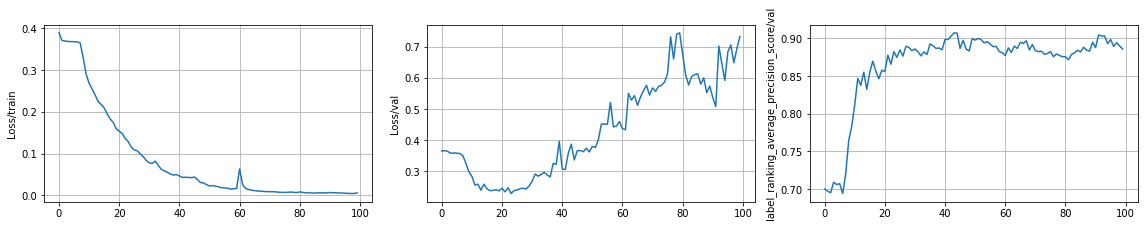

100%|██████████| 100/100 [17:52<00:00, 10.72s/it]


In [ ]:
trainer(dataloader_ir_train, dataloader_ir_test, epochs = 100)

In [ ]:
irpp.history_dict['label_ranking_average_precision_score/val']['First'][np.argmin(irpp.history_dict['Loss/val']['First'])]

0.6925939728861809

In [ ]:
from sklearn.metrics import label_ranking_average_precision_score
score_list = []
for i, j in dataloader_ir_val:
  model1.eval()
  model1.to(device)
  out = model1(i.to(device))
  #print(out)
  #print(j)
  score = label_ranking_average_precision_score(j, out.cpu().detach().numpy())
  score_list.append(score)
print(round(sum(score_list)/len(score_list), 2))

0.87


# Оценка качества модели

sklearn metrics - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


# Выводы

# Статистика

Базовая модель - 0: 8 сверточных слоёв (3 макспула, после каждого удвоения признаков). hidden_size = 11. Точность 0.6 на 100 эпохах (переобучение). lr = 0.001
Количество параметров: порядка 18 млн

v0.1. 8 сверточных (3 макспула, удвоение 1 после второго). hidden_size = 11. Точность 0,45 на 40 эпохах, потом переобучение до 0,6. lr = 0.0005.
Количество параметров: 5,058,328

v0.2.0 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 hidden_size = 11.сверточный слой. Hidden_size = 11. ;r = 0.0005. Точность 0.43 20 эпохах, потом переобучение. 
Количество параметров: 350,158

v0.2.0.1 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой. Hidden_size = 20. lr = 0.0005. Точность 0.41 на 20 эпохах, потом переобучение. 
Количество параметров: 655,357

v0.2.1 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5). Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score 0,875 на 25 эпохах, потом переобучение. 
Количество параметров: 3,753,407

